# Circuit submission

After working a while with simulators you might feel curious about what would look like if you run it on hardware. Well let's find out.

## Create the circuit

First you need to create your own circuit, let's start with something simple like a 5 qubit $|GHZ\rangle$ state.

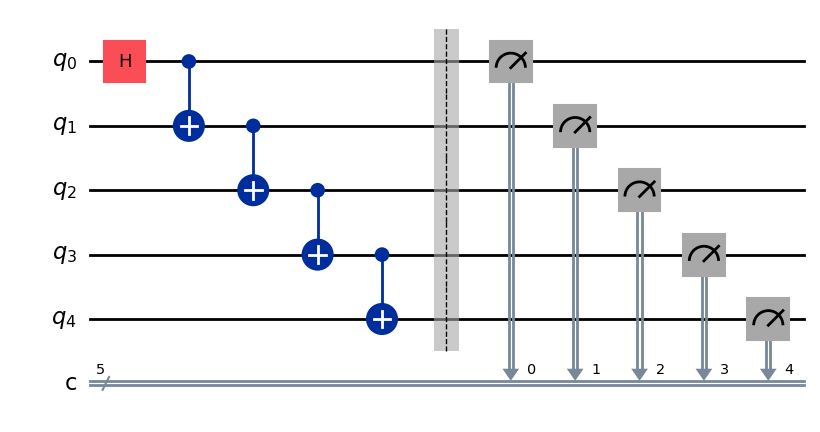

In [1]:
from qiskit import QuantumCircuit

num_qubits = 5

qc = QuantumCircuit(num_qubits, num_qubits)

# Superposition of 0 qubit
qc.h(0)
for i in range(1, num_qubits):
    qc.cx(i-1,i)

# Measure all
qc.measure_all(add_bits=False)
qc.draw('mpl')

You can simulate it locally and check the result in this case.

In [2]:
from qiskit_aer import AerSimulator

# execute the quantum circuit
simulator = AerSimulator()

result = simulator.run(qc, shots=1000).result()
counts  = result.get_counts(qc)
print(counts)

{'00000': 487, '11111': 513}


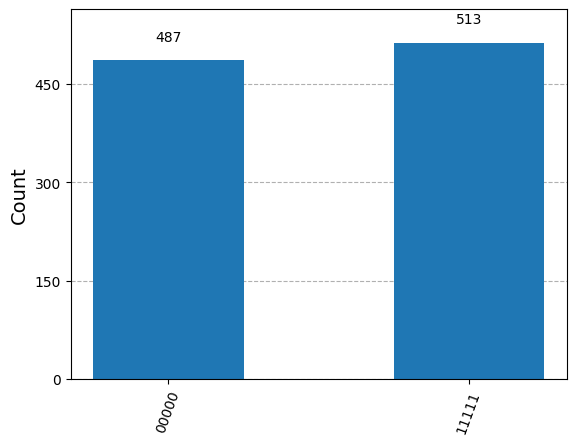

In [3]:
from qiskit.visualization import plot_histogram

plot_histogram(counts)

Perfect! Now, we can go for a device and see what we get.

## Instantiate your account

If you already have a Qiskit Platform account, you might need to retrieve the API token in order to identify yourself. I recommend you use some environment variable handling library like [python-dotenv](https://saurabh-kumar.com/python-dotenv/).

In [11]:
from dotenv import load_dotenv

load_dotenv(override=True)

True

Now we simply need to import the variables in a _.env_ file. This allows for environment variables to be separated and isolated from versioning. You just need to create that file locally and put there your variables like this:

```sh
QISKIT_API_KEY=<token>
QISKIT_QPU=<device>
```

You can get those from the IBM Quantum Platform itself. That way those variables are loaded locally

```py
import os

qiskit_api_key = os.environ.get("QISKIT_API_KEY")
qiskit_qpu = os.environ.get("QISKIT_QPU")
```

And one can store the account information for future usages.

```py
from qiskit_ibm_runtime import QiskitRuntimeService

QiskitRuntimeService.save_account(
    token=qiskit_api_key, # Your token is confidential.
    set_as_default=True, # Optionally set these as your default credentials.
)
```


We have selected *ibm_sherbrooke* from the three devices available with the [open plan](https://www.ibm.com/quantum/pricing) that allows you to submit circuits for up to 10 minutes.

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
backend = service.backend(qiskit_qpu)

After the backend is selected some information can be accessed, like how many jobs are in queue or if the device is available.

In [48]:
backend.status()

This means 223 jobs are ahead of us, whatever we submit may have to wait for a while. And also, the device seems to be in maintenance, so it might take even longer.

An interesting visualization is the connectivity map (how each qubit can be connected to the rest) and the error map (systematic error statistics collected during the last evaluation of the device).

We can see below how qubit 121 has a huge readout error or that qubit 64 has a bit error when used for Hadamard or CNOT gates. This will significantly affect our execution if those qubits are involved.

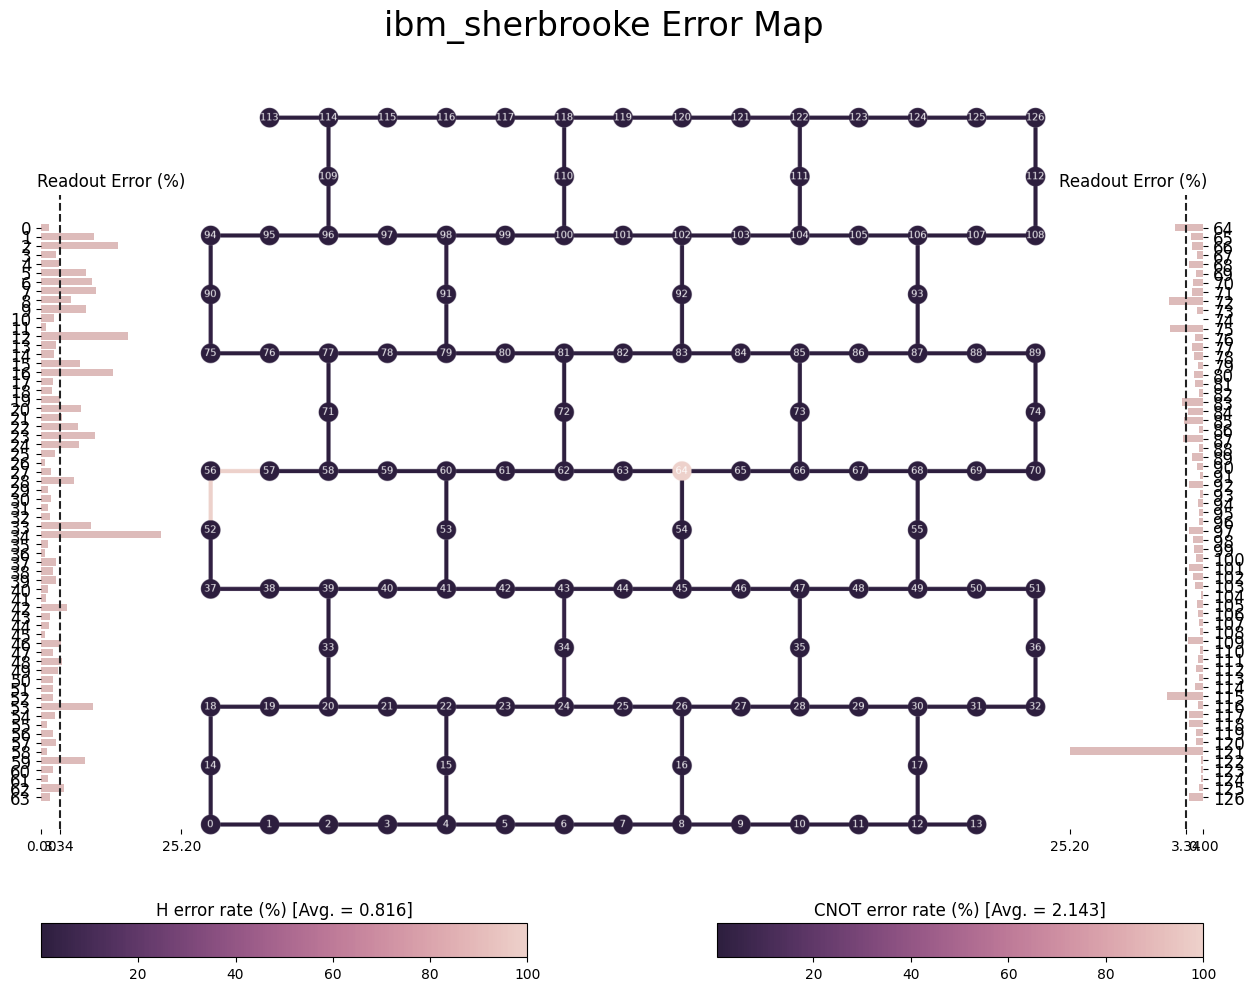

In [17]:
from qiskit import visualization

visualization.plot_error_map(backend)

A critical thing we need to take care of is the circuit **transpilation**, which means, adapting it to the backend it will run on. Qiskit simplifies this step by a simple command but you can dig deeper and make further optimization so that the execution will be as close as possible to the ideal run.

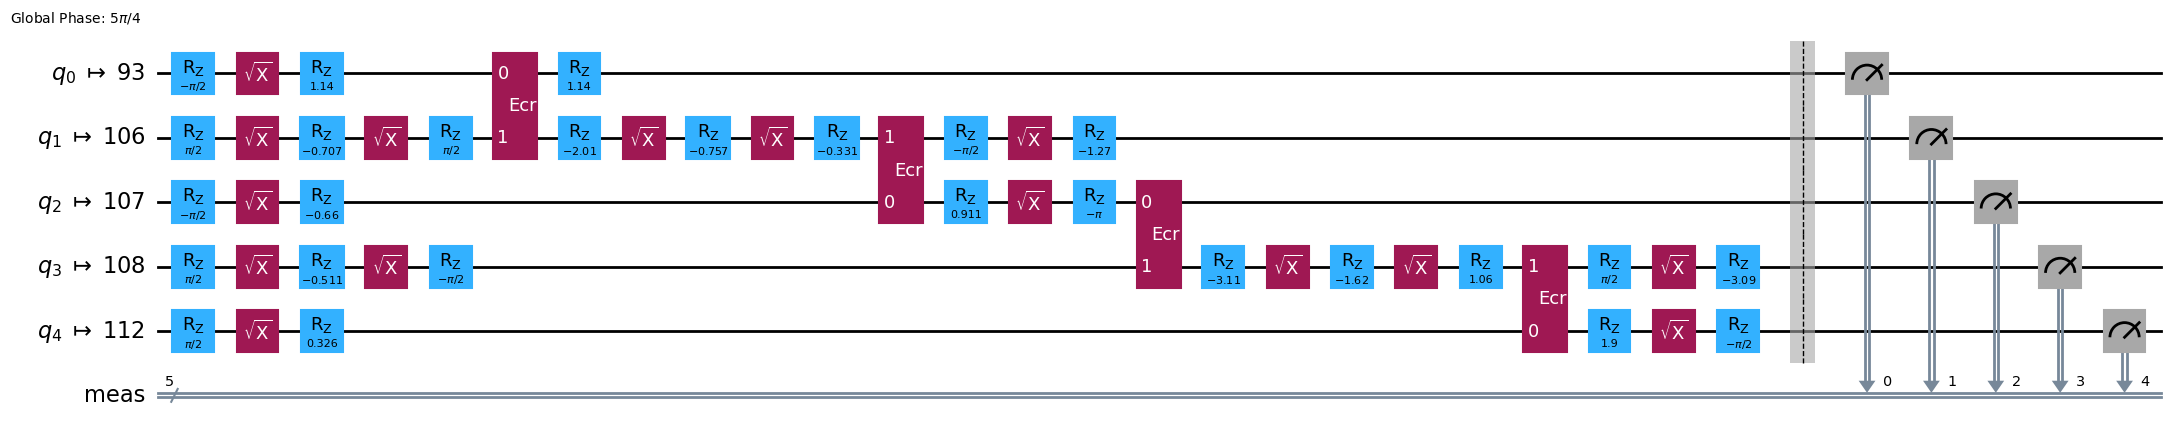

In [23]:
from qiskit import transpile

isa_circuit = transpile(qc, backend=backend)
isa_circuit.draw('mpl', idle_wires=False, fold=-1)

Specific qubits have been selected that allow for the connectivity to take place, prioritizing low error rates. Also, Hadamard and CNOT gates have been translating to those available in the device, like $\sqrt{X}$ and $Z$ rotation gates for replacing $H$ gate, and $E_{cr}$ for two qubit interactions.

:::{.callout-warning collapse="true"}
# Native gates

More on IBM chip native gates can be found [here](https://quantum.cloud.ibm.com/docs/es/guides/native-gates). Pay attention that those gates are chip architecture specific so depending on the QPU you select those gates above may not be the right ones.
:::

In [ ]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

# Define Sampler
sampler = Sampler(mode=backend)
 
# Run calculation
job = sampler.run([isa_circuit])

print(f"This is your job id {job.job_id()}")

This is your job id d1mfk139fb3c73eirst0


We will need to wait for a while now. You can periodically call the status function until it tells you it has finished.

In [28]:
job.status()

'DONE'

Now results can be retrieved and you should see the effect on the noise.

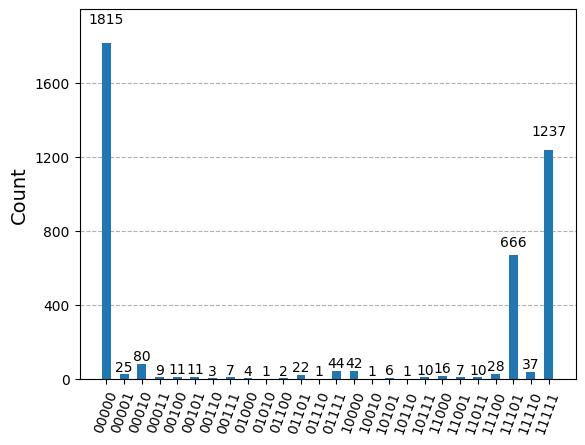

In [ ]:
from qiskit.visualization import plot_histogram

result = job.result()
counts = result[0].data.meas.get_counts()
plot_histogram(counts)

Well, not the ideal run we were expecting. It might have to do with device noise and errors... I guess. You can find plenty on how much optimization you can squeeze into these devices in IBM's [documentation](https://quantum.cloud.ibm.com/docs/es/tutorials/circuit-transpilation-settings). Do not hesitate checking it out.

:::{.callout-note collapse="true"}
# Noise modelling

In the past it was possible to model the noise and insert it into the simulator to run locally something that would resemble the hardware execution but it is getting harder and harder given that a 133 qubit device like the one we used requires a lot of resources to perform a full [density matrix simulation](../gettingstarted/classicalqc.qmd#simulators).

:::